Intelligent background subtraction algorithm using wavelets.

Also contains implementations of other wavelets and peak-finding code

Runs 2017/1/9

# Find and Subtract background 

In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy import signal

## Find Peaks

Use method in P. Du, W. A. Kibbe, S. M. Lin, Bioinformatics 2006, 22, 2059. Same as in scipy.signal.find_peaks_cwt() and baselineWavelet

### Wavelet transform

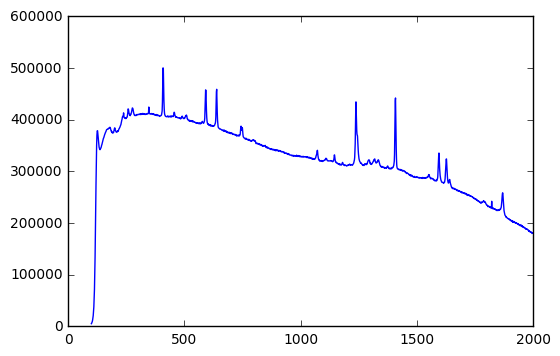

In [2]:
data1 = np.genfromtxt(os.path.join('..', 'tests', 'data', 'raman-785nm.txt'))
x = data1[:, 0]
y = data1[:, 1]
plt.plot(x, y)

### Find ridge lines 

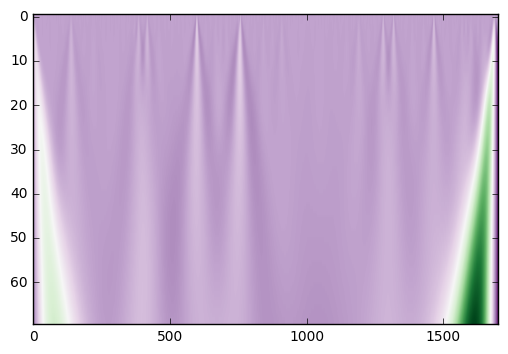

In [3]:
widths = np.arange(1,71)
cwtmat = signal.cwt(y, signal.ricker, widths)
plt.imshow(cwtmat, aspect='auto', cmap='PRGn')

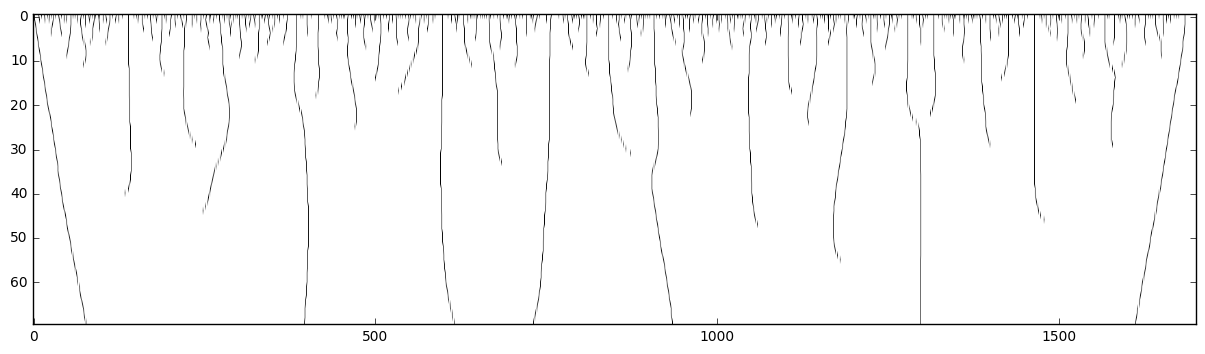

In [4]:
# Find local maxima
# make a binary array containing local maximum of transform, with same shape
lmax = np.zeros(cwtmat.shape)
for i in range(cwtmat.shape[0]):
    lmax[i, signal.argrelextrema(cwtmat[i, :], np.greater)] = 1
fig, ax = plt.subplots(figsize=(15, 4))
ax.imshow(lmax, aspect='auto', cmap='gray_r')

In [5]:
# allocate memory

# intial location assigned to peak from the first row
peak_pos_start = np.where(lmax[0,:]==1)[0]

# current position of the ridge
peak_ridge = np.copy(peak_pos_start)  # full copy

n_peaks = peak_pos_start.size

# length of the ridge
peak_len = np.ones(n_peaks)

# use the max of the ridge line to find the width of the peaks
peak_pos = np.zeros(n_peaks, dtype='int')
peak_width = np.ones(n_peaks)
peak_width_max = np.zeros(n_peaks)

In [6]:
# Link local maxima (find ridges)

w = 3

# for each row starting at the second
for i in range(1, lmax.shape[0]):
    # for each peak
    for j in range(n_peaks):
        # assume it doesn't extend, and then check
        extends = False
        p = peak_ridge[j]
        if lmax[i, p] == 1:
            # if there is one below, it is part of the same ridge
            extends = True
        else:
            # if not search around peak 
            for k in range(1, w):
                if lmax[i, p-k] == 1:
                    extends = True
                    peak_ridge[j] -= k
                    break
                elif lmax[i, p+k] == 1:
                    extends = True
                    peak_ridge[j] += k
                    break
        # if it extends
        if extends:
            # it it longer
            peak_len[j] += 1
            # find width by comparing max vs. previous
            if cwtmat[i, p] > peak_width_max[j]:
                peak_width_max[j] = cwtmat[i, p]
                peak_width[j] = i
                peak_pos[j] = p

In [7]:
print peak_pos[:20]
print peak_width[:20]

[75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75]
[ 69.  69.  69.  69.  69.  69.  69.  69.  69.  69.  69.  69.  69.  69.  69.
  69.  69.  69.  69.  69.]


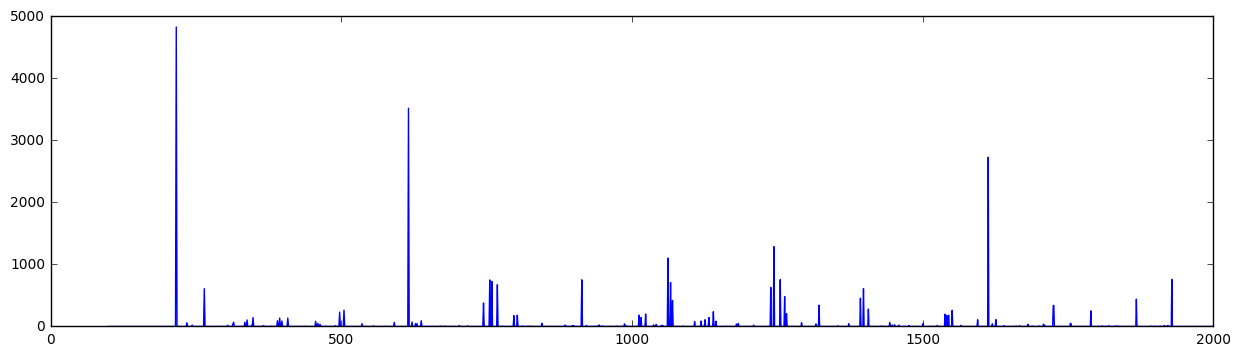

In [8]:
# generate a simulated spectrum of sorts, with peak positions and the length of the ridge lines
ypeaks = np.zeros(y.shape)
ypeaks[peak_pos] = peak_len*peak_width
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(x, ypeaks)

In [9]:
# find peaks using the first ridge position, last ridge position as well using find_peaks
peaks = signal.find_peaks_cwt(y, wavelet=signal.ricker, widths=widths)
peaks_2 = peak_pos[np.all(((peak_width > 0), (peak_len > 5)), axis=0)]


In [10]:
print peaks, peaks_2

[4, 139, 221, 274, 385, 417, 459, 598, 667, 756, 841, 907, 1048, 1145, 1188, 1278, 1316, 1384, 1463, 1512, 1577, 1682] [  75   75   75   75   75   75   75   75   75   75   75   75   75   75   75
   75   75   75   75   75   89   89  112  139  171  188  220  220  220  255
  256  256    0  285  285  285  285  286  286  286  301  303  330  330  344
  345  371  385  398  398  416  444  444  459  465  468  471  471  484  485
  508  508  531  531  548  548  563  598  606  611  630  648  648  678  678
  678  678  683  706  706  733  740  750  755  782  806  809  841  845  852
  858  874  874  908  911  915    0  923  925  933  933  949  949  956  959
  978  981 1014 1019 1045 1045 1069 1070 1104 1124 1132 1140 1140 1145 1162
 1162 1169 1169 1177 1180 1189 1189 1224    0    0 1251 1278 1296 1316 1361
 1361 1386 1386 1392 1398 1425 1463 1495 1510 1512 1518 1536 1537 1575 1575
 1575 1575 1598 1598 1612 1612 1612 1612 1612 1612 1612 1612 1612 1612 1612
 1612 1612 1612 1612]


For now use `scipy.signal.find_peaks_cwt()`, compare with my own implementation

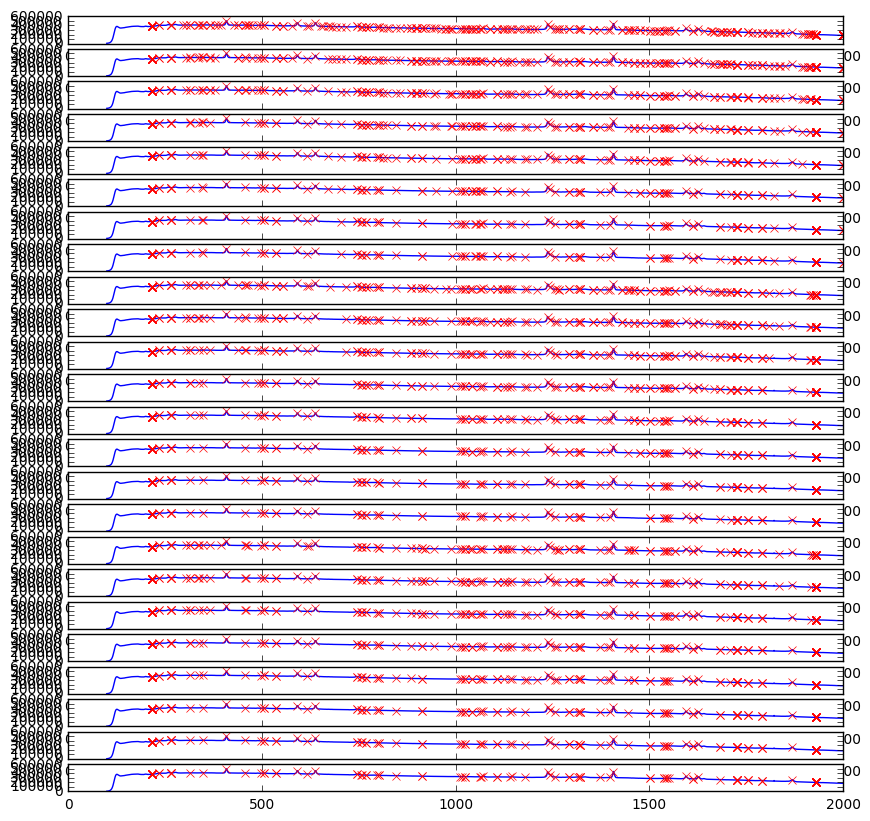

In [11]:
fig, ax = plt.subplots(24, figsize=(10,10))
for w in range(3):
    for l in range(2, 10):
        a = ax[w*8 + (l-2)]
        peaks = peak_pos[np.all(((peak_width > w), (peak_len > l)), axis=0)]
        a.plot(x,y)
        a.plot(x[peaks], y[peaks], 'rx', label='w%i, l%i' % (w,l))
        #a.legend()

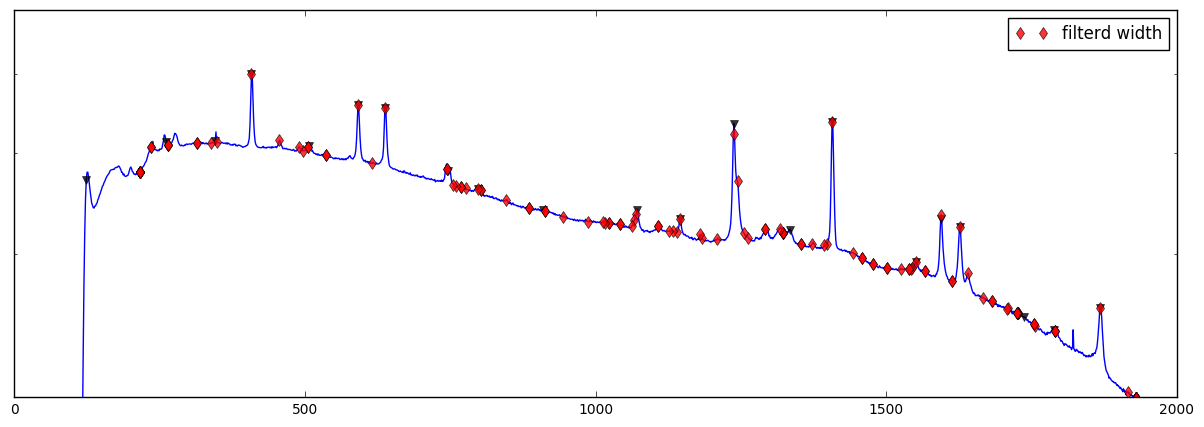

In [12]:
# find peaks using the first ridge position, last ridge position as well using find_peaks
peaks = signal.find_peaks_cwt(y, wavelet=signal.ricker, widths=widths)
peaks_2 = peak_pos[np.all(((peak_width > 1), (peak_len > 5)), axis=0)]

fig, ax = plt.subplots(figsize=(15,5))
ax.semilogy(x,y)
ax.semilogy(x[peaks], y[peaks], 'kv', alpha=0.8)
ax.semilogy(x[peaks_2], y[peaks_2], 'rd', alpha=0.8, label='filterd width')
#ax.plot(x[peaks_3], y[peaks_3], 'bx', label='filterd length')
ax.set_ylim(200000,600000)
ax.legend()

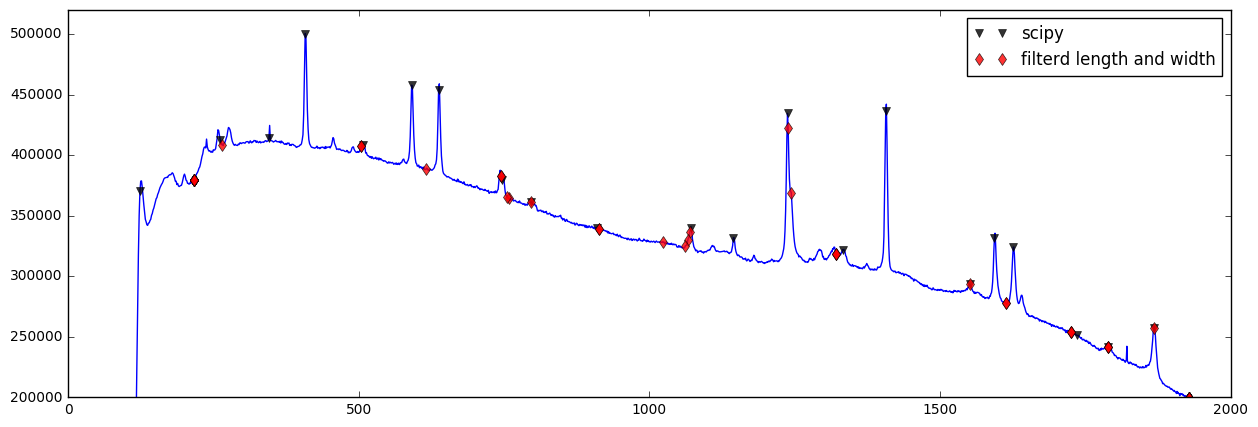

In [13]:
# find peaks using the first ridge position, last ridge position as well using find_peaks
peaks = signal.find_peaks_cwt(y, wavelet=signal.ricker, widths=widths)
peaks_2 = peak_pos[np.all(((peak_width > 5), (peak_len > 20)), axis=0)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x,y)
ax.plot(x[peaks], y[peaks], 'kv', alpha=0.8, label='scipy')
ax.plot(x[peaks_2], y[peaks_2], 'rd', alpha=0.8, label='filterd length and width')
#ax.plot(x[peaks_3], y[peaks_3], 'bx', label='filterd length')
ax.set_ylim(200000,520000)
ax.legend()

## Estimate Peak widths

Procedure from Zhang et al.

1. Perform CWT with Haar wavelet w/ same scales as peak finding. Result M x N matrix
2. Take abs of all values
3. For each peak in peak-detection there are two parameter: index and scale
    a. Row corresponding to scale is taken out
    b. Search for local minima to three times of peak scale or next peak index
4. If local minima do not exist:
    a. Peak start or end point is min(3 x peak scale, next peak index)
    else
    b. Peaks boundaries are minima and min(...)
5. Repeat for all peaks

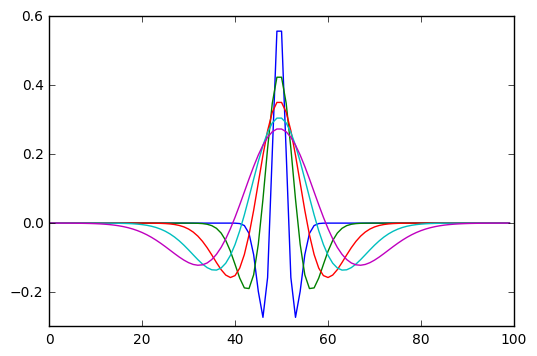

In [14]:
# analyze the ricker wavelet to help build the ricker wavelet
points = 100
for a in range(2, 11, 2):
    wave = signal.ricker(points, a)
    plt.plot(wave)

In [15]:
# note, all integrate to 0

In [16]:
# make a haar mother wavelet
def haar2(points, a):
    """
    Returns a haar wavelet mother wavelet
    
               1 if    0 <= t < 1/2
    h(t) =    -1 if  1/2 <= t < 1
               0 otherwise`
               
    Numpy version, not accurate right now
    """
    x = np.arange(0, points) - (points - 1.0) / 2
    wave = np.zeros(x.shape)
    amp = 2/a
    wave[np.where(np.logical_and(0 <= x, x < 0.5*a))[0]] = 1
    wave[np.where(np.logical_and(-0.5*a <= x, x < 1))[0]] = -1

    return wave*amp

In [17]:
# make a haar mother wavelet
def haar(points, a):
    """
    Returns a haar wavelet mother wavelet
    
               1 if    0 <= t < 1/2
    h(t) =    -1 if  1/2 <= t < 1
               0 otherwise`
    """
    vec = np.arange(0, points) - (points - 1.0) / 2
    wave = np.zeros(vec.shape)
    amp = 2/a
    for i, x in enumerate(vec):
        if 0 <= x < 0.5*a:
            wave[i] = 1
        elif -0.5*a <= x < 1:
            wave[i] = -1
    return wave*amp

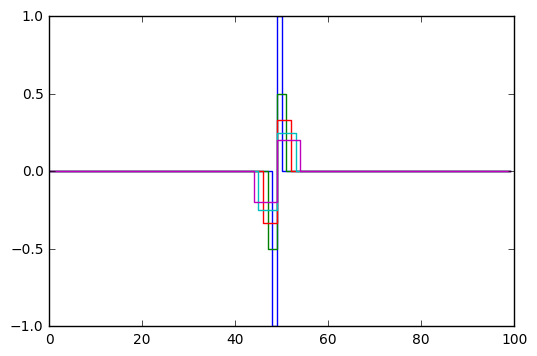

In [18]:
points = 100
for a in range(2, 11, 2):
    wave = haar(points, a)
    plt.step(np.arange(points), wave)

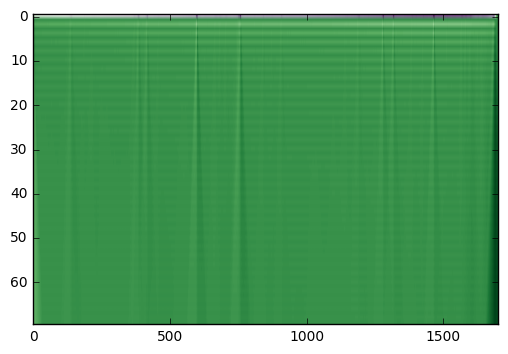

In [19]:
hw = signal.cwt(y, haar, widths=widths)
plt.imshow(hw, aspect='auto', cmap='PRGn')

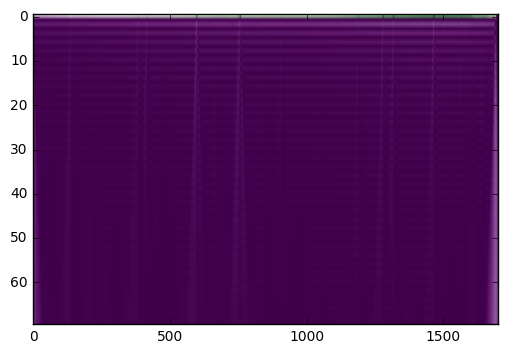

In [20]:
ahw = np.abs(hw)
plt.imshow(ahw, aspect='auto', cmap='PRGn')

Search for local minima in in the row corresponding to the peak's scale, within 3x peak scale or peak index

In [21]:
for p in peak_pos:
    print p

75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
82
82
88
89
89
95
97
102
106
112
0
0
0
0
139
0
0
0
159
0
0
171
175
179
0
188
0
194
200
207
0
220
220
220
232
0
0
245
0
255
256
256
0
0
285
285
285
285
286
286
286
0
0
301
303
310
311
0
0
322
323
330
330
0
0
344
345
350
353
0
0
0
371
385
391
398
398
0
416
0
0
0
0
0
444
444
0
0
0
459
465
468
471
471
477
479
484
485
0
493
498
0
508
508
0
0
520
0
531
531
0
0
0
548
548
555
559
563
571
577
577
0
0
598
606
611
0
0
0
630
0
0
0
0
648
648
0
0
0
0
678
678
678
678
683
0
0
0
0
0
706
706
0
0
721
0
730
730
733
740
750
755
0
0
0
782
0
789
0
0
797
0
0
806
809
0
818
823
829
0
841
845
852
858
858
864
874
874
0
0
0
892
892
0
0
908
911
915
0
923
925
933
933
937
0
944
949
949
956
959
964
0
973
978
981
985
992
994
0
1002
0
0
1014
1019
1022
1025
0
0
0
1038
1038
1045
1045
1058
1056
1060
0
1069
1070
1079
0
0
0
1094
0
1104
0
0
0
1119
1124
0
1132
1140
1140
1145
0
0
0
1162
1162
0
1169
1169
1177
1180
1189
1189
0
0
0
0
1212
0
0
1224
0
0
1233
0
1243
1246
125